# 5.1 Criação de Modelos de Machine Learning - Tunning

## ---- Nao considerado, usar arquivo analise_ml_tunning_ada ----

## Carregar dados tratados

In [63]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [64]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, recall_score

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.neural_network import MLPClassifier

import joblib

In [65]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [66]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("Recall: ", recall_score(y_teste, y_prev))
    print("#" * 50)
    return recall_score(y_teste, y_prev)


# ML modelos

## Modelos a serem testados

- Random Forest
- Gradient Boost
- AdaBoost

In [84]:
def definir_modelos_ml() -> dict:
    return {
        # "AdaBoost": {'modelo_base': AdaBoostClassifier(random_state=42), 'modelo_tunado': None},
        "AdaBoost": {'modelo_base': AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.1, algorithm='SAMME'), 'modelo_tunado': None},
        # "RedeNeural": {'modelo_base': MLPClassifier(random_state=42), 'modelo_tunado': None},
        "RedeNeural": {'modelo_base': MLPClassifier(random_state=42, solver='sgd', learning_rate='constant', hidden_layer_sizes=8, activation='relu'), 'modelo_tunado': None},
        "GradientBoost": {'modelo_base': GradientBoostingClassifier(random_state=42, n_estimators=1000, min_samples_split=10, max_features='auto', learning_rate=0.01, criterion='squared_error'), 'modelo_tunado': None},
        # "GradientBoost": {'modelo_base': GradientBoostingClassifier(random_state=42), 'modelo_tunado': None},
    }

In [68]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        avaliar(y_teste, previsoes, nome + '_base')
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

# Execucao

(1852, 6)
AdaBoost_base
Reporte teste
              precision    recall  f1-score   support

           0       0.55      0.37      0.44       142
           1       0.51      0.69      0.59       136

    accuracy                           0.53       278
   macro avg       0.53      0.53      0.51       278
weighted avg       0.53      0.53      0.51       278



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


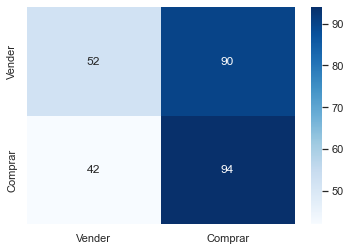

Recall:  0.6911764705882353
##################################################
RedeNeural_base
Reporte teste
              precision    recall  f1-score   support

           0       0.53      0.81      0.64       142
           1       0.56      0.25      0.35       136

    accuracy                           0.54       278
   macro avg       0.54      0.53      0.49       278
weighted avg       0.54      0.54      0.50       278



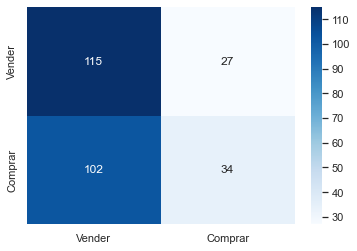

Recall:  0.25
##################################################
GradientBoost_base
Reporte teste
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       142
           1       0.52      0.60      0.56       136

    accuracy                           0.54       278
   macro avg       0.54      0.54      0.53       278
weighted avg       0.54      0.54      0.53       278



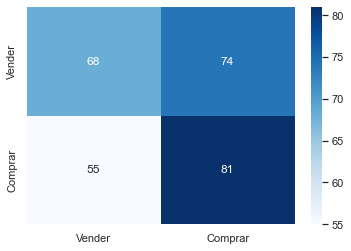

Recall:  0.5955882352941176
##################################################


In [85]:
def main():

    df = carregar_joblib()

    print(df.shape)

    # split database train and test
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste)

    return df, modelos

df, modelos = main()

## Tunning dos 3 melhores modelos

In [70]:
def fit_tunning_rand_search_ada(X_treino, y_treino):
    print("Tunning randomized search AdaBoost")

    # Create the random grid
    param = {'n_estimators': [50, 80, 90, 100],
             'learning_rate': [0.2, 1.0, 0.1],
             'algorithm': ["SAMME", "SAMME.R"]}

    print(param)

    rf_random = RandomizedSearchCV(estimator=AdaBoostClassifier(),
                                   param_distributions=param,
                                   cv=3,
                                   verbose=0,
                                   scoring="recall",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [94]:
def fit_tunning_rand_search_nn(X_treino, y_treino):
    print("Tunning randomized search NN")
    activation = ['relu', 'logistic', 'tanh']
    learning_rate = ["constant", "adaptive"]
    solver = ['sgd']
    hidden_layer_sizes = [3, 5, 8]

    # Create the random grid
    random_grid = {'activation': activation,
                   'solver': solver,
                   'learning_rate': learning_rate,
                   'hidden_layer_sizes': hidden_layer_sizes,
                   'random_state': [2, 42]
                   }

    print(random_grid)

    rf_random = RandomizedSearchCV(estimator=MLPClassifier(random_state=42),
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   cv=3,
                                   verbose=0,
                                   random_state=42,
                                   scoring="recall",
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [72]:
def fit_tunning_rand_search_gradient(X_treino, y_treino):
    print("Tunning randomized search Gradient Boost")

    # Create the random grid
    params = {'n_estimators': [800, 900, 1000],
                   'learning_rate': [0.01, 0.015, 0.009],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_split': [2, 5, 10],
                   'criterion': ["friedman_mse", "squared_error"]}

    print(params)

    rf_random = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=params,
                                   cv=3,
                                   verbose=0,
                                   scoring="recall",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [73]:

def run_ada_boost_tunning(df):

    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)
    
    resultado_grid = fit_tunning_rand_search_ada(X_treino.values, y_treino.values)

    print("Ajuste Adaboost feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [81]:

def run_nn_tunning(df):

    # split database train and test
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]
    
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    # run randomized search first, then set params for grid
    resultado_grid = fit_tunning_rand_search_nn(X_treino, y_treino)

    print("Ajuste Rede neural feito")

    print("best params", resultado_grid.best_params_)
    print("best score", resultado_grid.best_score_)
    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [82]:

def run_gradient_boost_tunning(df):


    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    resultado_grid = fit_tunning_rand_search_gradient(X_treino, y_treino)

    print("Ajuste Gradient Boost feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [76]:
def compare_tunning(df, modelos: dict):

    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    _, X_teste, _, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    recalls = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        # avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        recalls[nome] = avaliar(y_teste, prev, nome + '_tunado')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    

In [79]:
def run_tunning_fit(df, modelos):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['AdaBoost']['modelo_tunado'] = run_ada_boost_tunning(df)
    modelos['RedeNeural']['modelo_tunado'] = run_nn_tunning(df)
    modelos['GradientBoost']['modelo_tunado'] = run_gradient_boost_tunning(df)

    return modelos


Tunning randomized search AdaBoost
{'n_estimators': [50, 80, 90, 100], 'learning_rate': [0.2, 1.0, 0.1], 'algorithm': ['SAMME', 'SAMME.R']}
Ajuste Adaboost feito
Best params {'n_estimators': 50, 'learning_rate': 0.1, 'algorithm': 'SAMME'}
Best score 0.7238421955403087
Tunning randomized search NN
{'activation': ['relu', 'logistic', 'tanh'], 'solver': ['sgd'], 'learning_rate': ['constant', 'adaptive'], 'hidden_layer_sizes': [3, 5, 8], 'random_state': [2, 42]}


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

Ajuste Rede neural feito
best params {'solver': 'sgd', 'random_state': 42, 'learning_rate': 'constant', 'hidden_layer_sizes': 5, 'activation': 'relu'}
best score 0.9065656565656566
Tunning randomized search Gradient Boost
{'n_estimators': [800, 900, 1000], 'learning_rate': [0.01, 0.015, 0.009], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'criterion': ['friedman_mse', 'squared_error']}
Ajuste Gradient Boost feito
Best params {'n_estimators': 1000, 'min_samples_split': 10, 'max_features': 'auto', 'learning_rate': 0.01, 'criterion': 'squared_error'}
Best score 0.5927434724604536
AdaBoost_tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.55      0.37      0.44       142
           1       0.51      0.69      0.59       136

    accuracy                           0.53       278
   macro avg       0.53      0.53      0.51       278
weighted avg       0.53      0.53      0.51       278



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


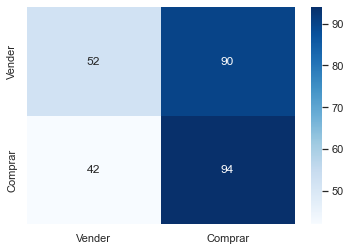

Recall:  0.6911764705882353
##################################################
RedeNeural_tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       142
           1       0.49      0.48      0.48       136

    accuracy                           0.50       278
   macro avg       0.50      0.50      0.50       278
weighted avg       0.50      0.50      0.50       278



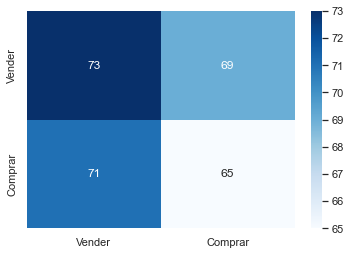

Recall:  0.47794117647058826
##################################################
GradientBoost_tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       142
           1       0.52      0.60      0.56       136

    accuracy                           0.54       278
   macro avg       0.54      0.54      0.53       278
weighted avg       0.54      0.54      0.53       278



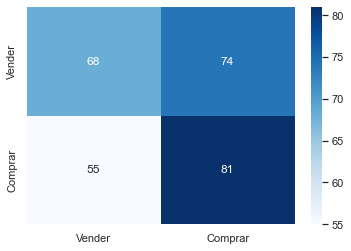

Recall:  0.5955882352941176
##################################################


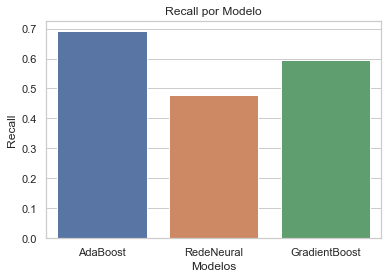

In [95]:
modelos = run_tunning_fit(df, modelos)

compare_tunning(df, modelos)

# Melhor modelo escolhido:

- x

Best score de x%